<a href="https://colab.research.google.com/github/Tejaasree/Tejasree_AdvancedMachineLearning/blob/main/Project/google_colab_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project- Deep Learning Models

Name: Tejasree Gottam

# Loading the dataset

In [ ]:
import zipfile

# ✅ Exact file name with space and parentheses
zip_path = '/content/archive (17).zip'
extract_path = '/content/fake_news_data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extraction complete.")


✅ Extraction complete.


In [ ]:
import os
import pandas as pd

data_path = "/content/fake_news_data"
print("Files extracted:", os.listdir(data_path))

csv_path = os.path.join(data_path, "Fake.csv")
df = pd.read_csv(csv_path)

df.head()


Files extracted: ['True.csv', 'Fake.csv']


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


# For binary classification, we will combine Fake.csv and True.csv into a single labeled dataset.

In [ ]:

true_df = pd.read_csv(os.path.join(data_path, "True.csv"))

df["label"] = 0
true_df["label"] = 1

news_df = pd.concat([df, true_df], ignore_index=True)
news_df = news_df.sample(frac=1).reset_index(drop=True)


news_df.head()


,title,text,subject,date,label
0,Trump voices mild optimism about ties with Nor...,PHOENIX (Reuters) - U.S. President Donald Trum...,politicsNews,"August 23, 2017",1
1,"Ramping up rhetoric, Turkey's Erdogan chastise...",ISTANBUL/ANKARA (Reuters) - Turkish President ...,worldnews,"October 21, 2017",1
2,BREAKING VIDEO: BRICKS AND ROCKS HURLED AT POL...,High school kids out of control? Noooo! We ve ...,politics,"Apr 27, 2015",0
3,"Militants cross from Afghanistan, kill two Pak...",ISLAMABAD (Reuters) - Militants have crossed i...,worldnews,"November 13, 2017",1
4,Person Majority Of Americans Voted For SHREDS...,It can easily be said that Donald Trump has ab...,News,"April 7, 2017",0


# Cleaning and Preprocessing Text
 The news text must be cleaned and preprocessed before being fed into a model.  This stage makes sure that training is not hampered by extraneous letters, punctuation, or unrelated words (such as stopwords).

In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

news_df['clean_text'] = news_df['text'].apply(clean_text)


news_df[['text', 'clean_text']].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,clean_text
0,PHOENIX (Reuters) - U.S. President Donald Trum...,phoenix reuters us president donald trump expr...
1,ISTANBUL/ANKARA (Reuters) - Turkish President ...,istanbulankara reuters turkish president tayyi...
2,High school kids out of control? Noooo! We ve ...,high school kids control noooo reporting huge ...
3,ISLAMABAD (Reuters) - Militants have crossed i...,islamabad reuters militants crossed pakistan a...
4,It can easily be said that Donald Trump has ab...,easily said donald trump absolutely idea regar...


# Text to Sequence Conversion  Making Use of Tokenization
 Raw text must be converted to numerical format since neural networks cannot comprehend it.  Each word is converted to an integer through tokenization, and all sequences are guaranteed to be the same length through padding.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


vocab_size = 10000
max_length = 250
oov_token = "<OOV>"


tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(news_df['clean_text'])

sequences = tokenizer.texts_to_sequences(news_df['clean_text'])

padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

print("Shape of padded sequences:", padded_sequences.shape)


Shape of padded sequences: (44898, 250)


# Split Train-Test
 To assess the success of a deep learning model, we must separate the data into training and testing sets before feeding it into the model.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, news_df["label"], test_size=0.2, random_state=42, stratify=news_df["label"]
)

print("Training samples:", len(X_train))
print("Testing samples :", len(X_test))


Training samples: 35918
Testing samples : 8980


# Construct the LSTM Model to Identify False News
 Building a deep learning model with LSTM (Long Short-Term Memory), which works well for problems involving the learning of text sequences.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


vocab_size = 10000
embedding_dim = 64
max_length = 250


model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# LSTM Model Training
 After defining and compiling our model, we use the training data (X_train, y_train) to train it.  This stage will enable the LSTM network to use backpropagation to modify its weights over multiple epochs and identify patterns in the input sequences.

In [ ]:

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=128,
    verbose=2
)


Epoch 1/10
281/281 - 6s - 21ms/step - accuracy: 0.7402 - loss: 0.5140 - val_accuracy: 0.7827 - val_loss: 0.4496
Epoch 2/10
281/281 - 4s - 13ms/step - accuracy: 0.8029 - loss: 0.4248 - val_accuracy: 0.8514 - val_loss: 0.3438
Epoch 3/10
281/281 - 4s - 13ms/step - accuracy: 0.7421 - loss: 0.4880 - val_accuracy: 0.5888 - val_loss: 0.6847
Epoch 4/10
281/281 - 4s - 13ms/step - accuracy: 0.6993 - loss: 0.5521 - val_accuracy: 0.9163 - val_loss: 0.2657
Epoch 5/10
281/281 - 4s - 13ms/step - accuracy: 0.9329 - loss: 0.2438 - val_accuracy: 0.5644 - val_loss: 1.0703
Epoch 6/10
281/281 - 4s - 13ms/step - accuracy: 0.9237 - loss: 0.2423 - val_accuracy: 0.9342 - val_loss: 0.2087
Epoch 7/10
281/281 - 4s - 13ms/step - accuracy: 0.9631 - loss: 0.1363 - val_accuracy: 0.9749 - val_loss: 0.0897
Epoch 8/10
281/281 - 4s - 13ms/step - accuracy: 0.9739 - loss: 0.0901 - val_accuracy: 0.9758 - val_loss: 0.0796
Epoch 9/10
281/281 - 4s - 13ms/step - accuracy: 0.9550 - loss: 0.1391 - val_accuracy: 0.9735 - val_loss:

## Visualize the Accuracy/Loss of Training and Validation

 By displaying accuracy and loss trends for both training and validation sets, this phase aids in our understanding of how effectively the model trained over time.  To identify overfitting or underfitting, these charts are crucial.

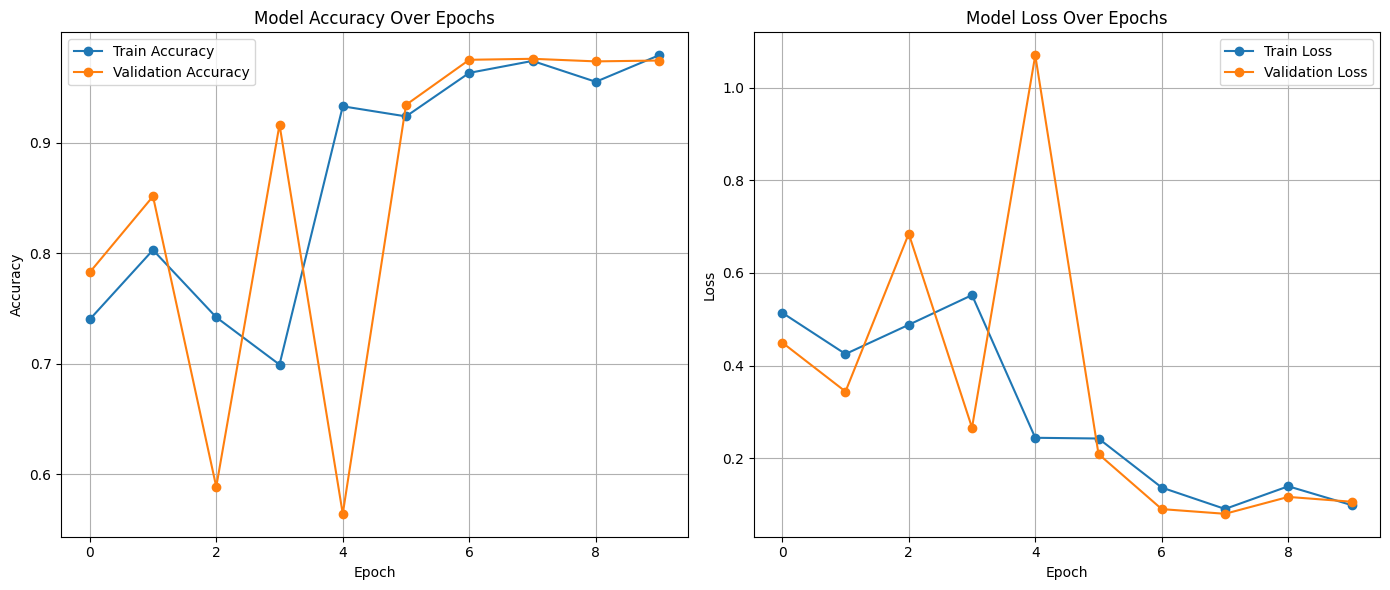

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Using Custom Headlines to Predict Real or Fake News
 We use fresh, unseen news items to evaluate our trained LSTM model's performance.  We may assess the model's ability to generalize outside of the training dataset by giving it custom instances.  By determining whether a headline is likely to be authentic or fraudulent, this mimics a real-world application, such as a false news identification tool.

In [ ]:

def predict_news(headlines):
    sequences = tokenizer.texts_to_sequences(headlines)
    padded = pad_sequences(sequences, maxlen=250, padding='post', truncating='post')
    predictions = model.predict(padded)

    for i, headline in enumerate(headlines):
        label = "Real" if predictions[i] > 0.5 else "Fake"
        confidence = predictions[i][0]
        print(f"\n Headline: {headline}")
        print(f" Prediction: {label} ({confidence:.2f} confidence)")

custom_headlines = [
    "NASA confirms water discovered on Mars surface",
    "Donald Trump caught hiding aliens in Area 51",
   "Bill Gates secretly funding weather control satellites",
    "COVID-19 vaccine proven 100% effective in new study",
    "Scientists develop plant that grows meat naturally",
]

predict_news(custom_headlines)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step

 Headline: NASA confirms water discovered on Mars surface
 Prediction: Fake (0.01 confidence)

 Headline: Donald Trump caught hiding aliens in Area 51
 Prediction: Fake (0.01 confidence)

 Headline: Bill Gates secretly funding weather control satellites
 Prediction: Fake (0.01 confidence)

 Headline: COVID-19 vaccine proven 100% effective in new study
 Prediction: Fake (0.01 confidence)

 Headline: Scientists develop plant that grows meat naturally
 Prediction: Fake (0.01 confidence)


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Final Test Accuracy: {acc:.4f}")

print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))

print("\n📊 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

✅ Final Test Accuracy: 0.9743

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      4696
           1       0.97      0.98      0.97      4284

    accuracy                           0.97      8980
   macro avg       0.97      0.97      0.97      8980
weighted avg       0.97      0.97      0.97      8980


📊 Confusion Matrix:
 [[4564  132]
 [  99 4185]]


In [ ]:
model.save("fake_news_lstm_model.h5")
print(" Model saved as fake_news_lstm_model.h5")


 Model saved as fake_news_lstm_model.h5
